In [414]:
import pandas as pd, os, os.path as op, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

u = lambda x: list(set(x))

#make necessary folders
if not op.exists('plots'):
    os.mkdir('plots')
    
    
    
#exgaussian (https://doi.org/10.3758/bf03200523)

def exgaussian(data, asDict = True):
    import numpy as np
    from scipy.stats import moment
    mean = np.nanmean(data)
    var = np.nanvar(data,ddof=1)
    tcm = np.sum((data[~np.isnan(data)] - np.nanmean(data))**3)/(len(data)-1)
    
    if tcm > 0:
        tau = (tcm/2)**(1/3)
    else:
        tau = 0.8 * np.nanstd(data, ddof=1)
    
    mu = mean - tau
    sigma = np.abs(var - tau**2)**(1/2)
    
    if asDict:
        return {"mu":mu, "sigma":sigma, "tau":tau}
    else:
        return mu, sigma, tau
    

#### Rename column names into ones that are bearable and fix some vars' values

In [209]:
q = pd.read_excel(op.join('data',"quest.xlsx"))
c = pd.read_excel(op.join('data',"cogn.xlsx"))

q = q.rename({'Participant Private ID':'id','Grupa':'group','Czy uzywa klawiatury i myszy zewnętrznej do gry lub pracy?':'keymouseuse',
         'Wiek':'age','Płec':'sex','Stan cywilny':'marital','Najwyższy ukonczony stopień edukacji':'edu',
          'Liczba ukończonych lat edukacji':'eduyears','Wielkość miasta zamieszkania':'size','Częstotliwość gry lub pracy':'pwfreq',
         'Ile pełnych lat gra lub pracuje':'pwyears','Średnia liczba godzin gry lub pracy dziennie w ostatnich 3 miesiącach':'pwhrsdaily3mo',
         'Średnia liczba godzin gry lub pracy tygodniowo w ostatnich 3 miesiącach':'pwhrsweeky3mo',
          'Czy kiedykolwiek czerpał korzyści materialne z grania w gry komputerowe?':'gainsever',
          'Czy obecnie utrzymuje się z grania w gry komputerowe?':'upkeepgamesnow',
         'Czy planuje kiedyś utrzymywać się z grania w gry komputerowe?':'upkeepgamesfuture'}, axis = 1)

c = c.rename({'Participant Private ID':'id','Zadanie':'task','Warunek':'condition',"Timed Out":'timeout'},axis=1)
c.columns = [col.lower() for col in c.columns]

q["group"] = q["group"].map({'Regularnie gram w League of Legends':"LoL",
                'Regularnie gram w Counter Strike: Global Offensive':"CS:GO",
                'Regularnie pracuję przy komputerze i nie gram w gry lub robię to rzadko (gry na konsole i smartfony nie są wliczane)':"Niegrający",
                'Regularnie pracuję lub uczę się przy komputerze i nie gram w gry lub robię to rzadko (gry na konsole i smartfony nie są wliczane)':"Niegrający"})

#drop columns with no variability
q = q.drop([col for col in q.columns if q[col].nunique() == 1],axis=1)


q['marital'] = q['marital'].map({'Kawaler/ panna':"Kawaler",'Żonaty/ zamężna':'Żonaty'})

#add group info to cognitive df
c["group"] = c['id'].map({pid:q[q['id'] == pid]['group'].values[0] for pid in q['id'].unique()})

#change nans into zeros, drop trials with more attempts than possible
c['attempt'] = c['attempt'].replace({np.nan:0})
c = c[c['attempt'] <= 5]

c['trialtype'] = c['task'].apply(lambda x: x.split(":")[-1])
c['task'] = c['task'].apply(lambda x: x.split(":")[0])
c['task'] = c['task'].map({'Go/No-Go':'gonogo','Cued Task Switching':'cts','Posner Cueing Task':'posner','Visual Search Click on Location':'vsc'})

#### Split cognitive data into separate dfs

In [211]:
cDict = {}

for task in u([t.split(":")[0] for t in c['task'].unique()]):
    cDict[task] = c[c.task.str.contains(task)]
    
    if task == 'gonogo':
        cDict[task]['trialtype'] = cDict[task]['trialtype'].apply(lambda x: x.split()[0])
    else:
        cDict[task] = cDict[task].drop(['trialtype'],axis=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


##### Go/No Go task preprocessing

In [417]:
d = cDict['gonogo'].copy()
d = d[d['rt'] >= 100]

d.loc[d["attempt"] == 0,'rt'] = np.nan
d['correct_'] = d['correct'].map({1:'correct',0:'incorrect'})

d['condcorr'] = d.apply(lambda x: f"{x['condition']} - {x['correct_']}", axis = 1)

In [418]:
#RT for each condition and correct/incorrect separately

dDescRT = d.groupby(['id','group','condition','condcorr']).agg(
    n = pd.NamedAgg(column='rt', aggfunc=np.size),
    rt_mean = pd.NamedAgg(column='rt', aggfunc=np.mean),
    rt_sd = pd.NamedAgg(column='rt', aggfunc=np.std),
    rt_mu = pd.NamedAgg(column='rt', aggfunc=lambda x: exgaussian(x)['mu']),
    rt_sigma = pd.NamedAgg(column='rt', aggfunc=lambda x: exgaussian(x)['sigma']),
    rt_tau = pd.NamedAgg(column='rt', aggfunc=lambda x: exgaussian(x)['tau'])
).reset_index()

#drop conditions where no RT occurs
dDescRT = dDescRT[~dDescRT['rt_mean'].isna()].fillna(0)

#RT regaradless of condition
dDescRT2 = d.groupby(['id','group']).agg(
    n = pd.NamedAgg(column='rt', aggfunc=np.size),
    rt_mean = pd.NamedAgg(column='rt', aggfunc=np.mean),
    rt_sd = pd.NamedAgg(column='rt', aggfunc=np.std),
    rt_mu = pd.NamedAgg(column='rt', aggfunc=lambda x: exgaussian(x)['mu']),
    rt_sigma = pd.NamedAgg(column='rt', aggfunc=lambda x: exgaussian(x)['sigma']),
    rt_tau = pd.NamedAgg(column='rt', aggfunc=lambda x: exgaussian(x)['tau'])
).reset_index()


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


In [449]:
dDescRT

,id,group,condition,condcorr,n,rt_mean,rt_sd,rt_mu,rt_sigma,rt_tau
0,2259446,LoL,Go,Go - correct,255.0,352.045196,56.922797,302.751698,28.466749,49.293499
3,2259446,LoL,No Go,No Go - incorrect,20.0,319.207250,33.718756,295.514443,23.991778,23.692807
4,2260116,LoL,Go,Go - correct,244.0,343.135840,63.876189,318.613671,58.981614,24.522170
7,2260116,LoL,No Go,No Go - incorrect,46.0,332.374891,55.410716,290.585694,36.386954,41.789197
8,2260229,LoL,Go,Go - correct,255.0,412.279000,60.254157,357.799323,25.739625,54.479677
...,...,...,...,...,...,...,...,...,...,...
197,2367440,CS:GO,No Go,No Go - incorrect,12.0,359.802500,35.199098,335.662847,25.617448,24.139653
198,2367631,CS:GO,Go,Go - correct,255.0,398.089824,43.530595,370.971194,34.051323,27.118630
201,2367631,CS:GO,No Go,No Go - incorrect,13.0,374.125769,33.341633,351.785441,24.750236,22.340328
202,2367802,Niegrający,Go,Go - correct,252.0,410.468254,55.979106,341.651702,40.025710,68.816552


In [481]:
dDescRTlong = pd.melt(dDescRT, id_vars = ["id","group","condition","condcorr"],
                      value_vars = [rt for rt in dDescRT.columns if "rt" in rt],var_name='parameter')
dDescRTlong['parameter'] = dDescRTlong['parameter'].apply(lambda x: x.split("_")[-1])
dDescRTlong['correct'] = dDescRTlong["condcorr"].apply(lambda x: x.split(" - ")[-1])

<AxesSubplot:xlabel='group', ylabel='rt_mean'>

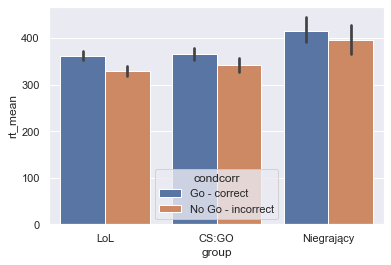

In [471]:
sns.barplot(data=dDescRT,x='group',y='rt_mean',hue='condcorr',order=['LoL',"CS:GO","Niegrający"])

In [482]:
dDescRTlong

,id,group,condition,condcorr,parameter,value,correct
0,2259446,LoL,Go,Go - correct,mean,352.045196,correct
1,2259446,LoL,No Go,No Go - incorrect,mean,319.207250,incorrect
2,2260116,LoL,Go,Go - correct,mean,343.135840,correct
3,2260116,LoL,No Go,No Go - incorrect,mean,332.374891,incorrect
4,2260229,LoL,Go,Go - correct,mean,412.279000,correct
...,...,...,...,...,...,...,...
590,2367440,CS:GO,No Go,No Go - incorrect,tau,24.139653,incorrect
591,2367631,CS:GO,Go,Go - correct,tau,27.118630,correct
592,2367631,CS:GO,No Go,No Go - incorrect,tau,22.340328,incorrect
593,2367802,Niegrający,Go,Go - correct,tau,68.816552,correct


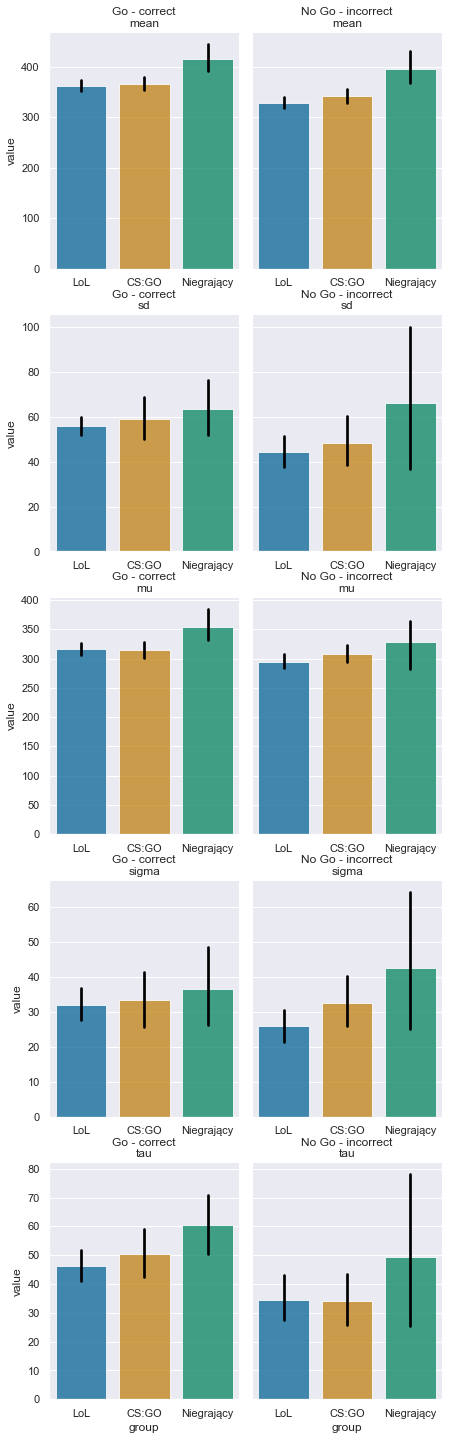

In [511]:
g = sns.FacetGrid(dDescRTlong, col='condcorr', row="parameter", height=4, aspect=.8,sharex=False, sharey='row')
plt.subplots_adjust(top=0.9)
g.map(sns.barplot,'group','value',palette = 'colorblind',alpha = .8,errcolor="black",order=['LoL',"CS:GO","Niegrający"])

axes = g.axes.flatten()

for i in range(len(axes)):
    axes[i].set_title("\n".join([tpart.split(" = ")[-1] for tpart in axes[i].get_title().split(" | ")[::-1]]))


In [447]:
dDescPerc = d.groupby(['id','group','condition','condcorr']).agg(n = pd.NamedAgg(column='rt', aggfunc=np.size)).reset_index()

dDescPerc['correct'] = dDescPerc['n']/dDescPerc.groupby(['id','condition'])["n"].transform(np.sum)
dDescPerc = dDescPerc[dDescPerc['condcorr'].str.contains('- correct')]
dDescPerc = dDescPerc.drop(['condcorr'],axis=1)

In [464]:
dDescPerc

,id,group,condition,n,correct
0,2259446,LoL,Go,255.0,0.996094
2,2259446,LoL,No Go,44.0,0.687500
4,2260116,LoL,Go,244.0,0.964427
6,2260116,LoL,No Go,18.0,0.281250
8,2260229,LoL,Go,255.0,1.000000
...,...,...,...,...,...
196,2367440,CS:GO,No Go,52.0,0.812500
198,2367631,CS:GO,Go,255.0,0.996094
200,2367631,CS:GO,No Go,51.0,0.796875
202,2367802,Niegrający,Go,252.0,0.984375


<AxesSubplot:xlabel='group', ylabel='correct'>

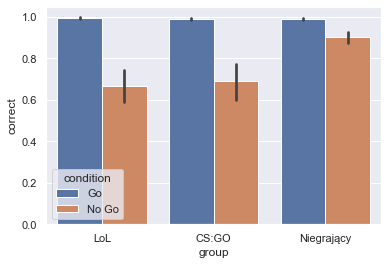

In [469]:
sns.barplot(data=dDescPerc,x='group',y='correct',hue='condition',order=['LoL',"CS:GO","Niegrający"])

#### Ogólny procent poprawnych odp, niezależnie od warunku

In [439]:
dDescPercGeneral = d.groupby(['id','group','correct_']).agg(n = pd.NamedAgg(column='rt', aggfunc=np.size)).reset_index()
dDescPercGeneral['correct'] = dDescPercGeneral['n']/dDescPercGeneral.groupby(['id'])["n"].transform(np.sum)
dDescPercGeneral = dDescPercGeneral[dDescPercGeneral['correct_'] == 'correct']
dDescPercGeneral = dDescPercGeneral.drop(['correct_'], axis=1)

In [441]:
dDescPercGeneral.head()

,id,group,n,correct
0,2259446,LoL,299.0,0.934375
2,2260116,LoL,262.0,0.826498
4,2260229,LoL,298.0,0.934169
6,2260318,LoL,300.0,0.937500
8,2260455,LoL,310.0,0.968750


<AxesSubplot:xlabel='group', ylabel='correct'>

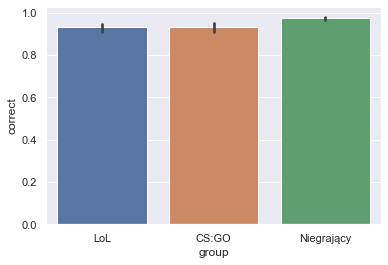

In [466]:
sns.barplot(data=dDescPercGeneral,x='group',y='correct',order=['LoL',"CS:GO","Niegrający"])

#### % correct dla P vs dla R

In [458]:
dpr = d.groupby(['id','group','correct_','trialtype']).agg(n = pd.NamedAgg(column='rt', aggfunc=np.size)).reset_index()

dpr['correct'] = dpr['n']/dpr.groupby(['id','trialtype'])["n"].transform(np.sum)
dpr = dpr[dpr['correct_'] == 'correct']
dpr = dpr.drop(['correct_'],axis=1)

In [459]:
dpr

,id,group,trialtype,n,correct
0,2259446,LoL,P,149.0,0.931250
1,2259446,LoL,R,150.0,0.937500
4,2260116,LoL,P,135.0,0.849057
5,2260116,LoL,R,127.0,0.803797
8,2260229,LoL,P,148.0,0.930818
...,...,...,...,...,...
229,2367440,CS:GO,R,148.0,0.930818
232,2367631,CS:GO,P,153.0,0.956250
233,2367631,CS:GO,R,153.0,0.956250
236,2367802,Niegrający,P,159.0,0.993750


##### Raczej nie ma istotnych statystycznie różnic między warunkami P i R

<AxesSubplot:xlabel='group', ylabel='correct'>

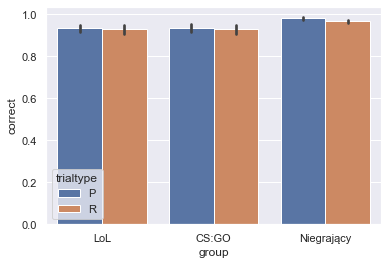

In [467]:
sns.barplot(data=dpr,x='group',y='correct',hue='trialtype',order=['LoL',"CS:GO","Niegrający"])

<AxesSubplot:xlabel='trialtype', ylabel='correct'>

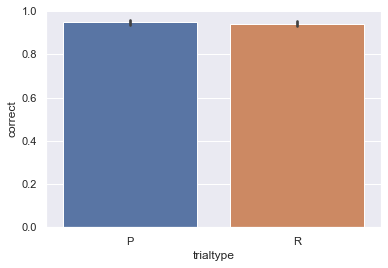

In [463]:
sns.barplot(data=dpr,x='trialtype',y='correct')